# Plot clade connectivity between timepoints

To ensure that clades are connected between timepoints, enabling model fitting across timepoints for all clades, plot the first timepoint each clade occurs in a network and connect adjacent clades with edges based on traversal of the tips-to-clades map for all timepoints.

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
data_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/tips_to_clades.tsv"

In [4]:
df = pd.read_csv(data_path, sep="\t", parse_dates=["timepoint"])

In [5]:
df.shape

(136451, 6)

In [6]:
df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Indonesia/1142/2006,993737c,1,h3n2,ha,2009-10-01
1,A/Indonesia/1142/2006,root,2,h3n2,ha,2009-10-01
2,A/Leiden/87509/2005,ffaf2a6,1,h3n2,ha,2009-10-01
3,A/Leiden/87509/2005,993737c,2,h3n2,ha,2009-10-01
4,A/Leiden/87509/2005,root,3,h3n2,ha,2009-10-01


In [7]:
sorted_df = df.sort_values(["timepoint", "tip", "depth"]).copy()

In [8]:
sorted_df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
2300,A/Afghanistan/AF1169/2008,5ea83cf,1,h3n2,ha,2009-10-01
2301,A/Afghanistan/AF1169/2008,1bd7f89,8,h3n2,ha,2009-10-01
2302,A/Afghanistan/AF1169/2008,0ecbd50,9,h3n2,ha,2009-10-01
2303,A/Afghanistan/AF1169/2008,61436b3,19,h3n2,ha,2009-10-01
2304,A/Afghanistan/AF1169/2008,c0e78de,20,h3n2,ha,2009-10-01


In [9]:
sorted_df["clade_membership"].unique().shape

(386,)

Create a graph that will connect all adjacent clades (essentially the original tree) and note the first timepoint each clade was observed.

In [10]:
tree = nx.Graph()

timepoint_by_clade_name = {"root": df["timepoint"].min() - pd.DateOffset(months=6)}
clade_id_by_name = {"root": 50}
observed_tips = set()

current_timepoint = None
for timepoint, timepoint_df in sorted_df.groupby("timepoint"):
    clade_counter = 0
    for tip, tip_df in timepoint_df.groupby("tip"):
        # Only consider the clade linkages for tips once when that tip is first observed.
        if tip in observed_tips:
            continue
        
        observed_tips.add(tip)
        clades = tip_df["clade_membership"].values

        # Loop through clades, adding edges between adjacent clades.
        for i in range(len(clades)):
            # Make sure each clade is represented in the tree.
            tree.add_node(clades[i])

            # Link each clade after the first one back to its relative.
            if i > 0:
                tree.add_edge(clades[i], clades[i - 1])

            # Note the first timepoint each clade was observed.
            if clades[i] not in timepoint_by_clade_name:
                timepoint_by_clade_name[clades[i]] = timepoint
                clade_id_by_name[clades[i]] = clade_counter
                clade_counter += 5

In [11]:
tip

'A/Zhuhai/676/2008'

In [12]:
tree["root"]

AtlasView({'eeb6263': {}, 'cec9051': {}, '993737c': {}})

In [13]:
tip_df

,tip,clade_membership,depth,lineage,segment,timepoint
118335,A/Zhuhai/676/2008,b2735ac,1,h3n2,ha,2015-10-01
118336,A/Zhuhai/676/2008,7e7b605,3,h3n2,ha,2015-10-01
118337,A/Zhuhai/676/2008,0ecbd50,4,h3n2,ha,2015-10-01
118338,A/Zhuhai/676/2008,0ba5f43,18,h3n2,ha,2015-10-01
118339,A/Zhuhai/676/2008,c0e78de,19,h3n2,ha,2015-10-01
118340,A/Zhuhai/676/2008,cec9051,21,h3n2,ha,2015-10-01
118341,A/Zhuhai/676/2008,root,28,h3n2,ha,2015-10-01


In [14]:
tree.number_of_nodes()

319

In [15]:
tree.number_of_edges()

344

In [16]:
clade_counter

70

In [17]:
positions = {clade: (timepoint_by_clade_name[clade].year + ((timepoint_by_clade_name[clade].month - 1) / 12.0), clade_id_by_name[clade])
             for clade in timepoint_by_clade_name}

In [18]:
list(positions.items())[:10]

[('root', (2009.25, 50)),
 ('5ea83cf', (2009.75, 0)),
 ('1bd7f89', (2009.75, 5)),
 ('0ecbd50', (2009.75, 10)),
 ('61436b3', (2009.75, 15)),
 ('c0e78de', (2009.75, 20)),
 ('cec9051', (2009.75, 25)),
 ('eeb6263', (2009.75, 30)),
 ('eacdfa7', (2009.75, 35)),
 ('bc5aa48', (2009.75, 40))]

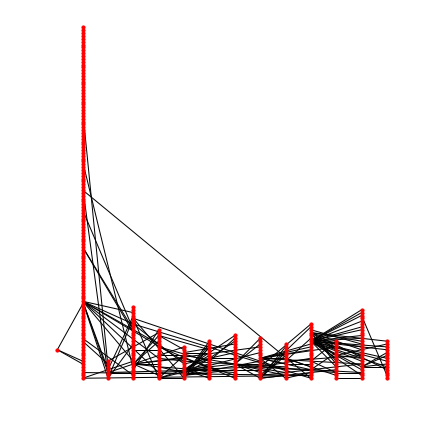

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw(
    tree,
    pos=positions,
    ax=ax,
    node_size=10
)
plt.tight_layout()

Look for nodes without any edges.

In [180]:
[node for node in tree if len(tree[node]) == 0]

[]

Look for nodes from the last timepoint that connect to nodes from more than one timepoint in the past.

In [181]:
recent_clades = [clade
                 for clade, timepoint in timepoint_by_clade_name.items()
                 if timepoint == df["timepoint"].max()]

In [182]:
recent_clades

['2a0ba9c', 'c380fce', '2998a82', '4ad67a4', '28d8a67', '256721e']

In [204]:
broken_clade = None
for recent_clade in recent_clades:
    for ancestor in tree[recent_clade]:
        delta = timepoint_by_clade_name[recent_clade] - timepoint_by_clade_name[ancestor]
        if delta.days > 400:
            print(recent_clade)
            broken_clade = recent_clade
            break
            
    if broken_clade is not None:
        break

28d8a67


In [205]:
recent_clade

'28d8a67'

In [206]:
df[df["clade_membership"] == broken_clade]

,tip,clade_membership,depth,lineage,segment,timepoint
33078,A/Yamanashi/182/2010,28d8a67,1,h3n2,ha,2012-10-01
33088,A/HoChiMinh/5677/2010,28d8a67,1,h3n2,ha,2012-10-01
33098,A/HoChiMinh/6388/2010,28d8a67,1,h3n2,ha,2012-10-01
33108,A/Alabama/5/2010,28d8a67,1,h3n2,ha,2012-10-01
33118,A/Vietnam/838/2010,28d8a67,1,h3n2,ha,2012-10-01


In [203]:
df[df["clade_membership"] == broken_clade].shape

(71, 6)

In [188]:
bahia_df = df[(df["tip"] == "A/Bahia/100/2011") & (df["timepoint"] == "2012-04-01")]

In [189]:
bahia_df

,tip,clade_membership,depth,lineage,segment,timepoint
26875,A/Bahia/100/2011,93a23e6,1,h3n2,ha,2012-04-01
26876,A/Bahia/100/2011,e4e39db,4,h3n2,ha,2012-04-01
26877,A/Bahia/100/2011,c3e824d,23,h3n2,ha,2012-04-01
26878,A/Bahia/100/2011,23082c4,25,h3n2,ha,2012-04-01
26879,A/Bahia/100/2011,475ef64,27,h3n2,ha,2012-04-01
26880,A/Bahia/100/2011,c512845,53,h3n2,ha,2012-04-01
26881,A/Bahia/100/2011,18d08a3,67,h3n2,ha,2012-04-01
26882,A/Bahia/100/2011,4f7d9e7,69,h3n2,ha,2012-04-01
26883,A/Bahia/100/2011,779a52a,70,h3n2,ha,2012-04-01
26884,A/Bahia/100/2011,root,72,h3n2,ha,2012-04-01


In [190]:
parana_df = df[(df["tip"] == "A/Parana/415/2012") & (df["timepoint"] == "2012-10-01")]

In [191]:
parana_df

,tip,clade_membership,depth,lineage,segment,timepoint
33325,A/Parana/415/2012,2998a82,1,h3n2,ha,2012-10-01
33326,A/Parana/415/2012,93a23e6,4,h3n2,ha,2012-10-01
33327,A/Parana/415/2012,e4e39db,6,h3n2,ha,2012-10-01
33328,A/Parana/415/2012,c3e824d,8,h3n2,ha,2012-10-01
33329,A/Parana/415/2012,23082c4,10,h3n2,ha,2012-10-01
33330,A/Parana/415/2012,475ef64,12,h3n2,ha,2012-10-01
33331,A/Parana/415/2012,c512845,26,h3n2,ha,2012-10-01
33332,A/Parana/415/2012,20ca0a9,41,h3n2,ha,2012-10-01
33333,A/Parana/415/2012,7c85126,42,h3n2,ha,2012-10-01
33334,A/Parana/415/2012,779a52a,44,h3n2,ha,2012-10-01


In [192]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [193]:
tips[tips["strain"] == "A/Bahia/100/2011"]

,strain,clade_membership,timepoint,frequency
180,A/Bahia/100/2011,e4e39db,2011-04-01,0.022784


In [194]:
# Identify distinct clades per timepoint.
clades = tips.loc[:, ["timepoint", "clade_membership"]].drop_duplicates().copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})

In [195]:
clades[clades["clade_membership"] == "e4e39db"]

,initial_timepoint,clade_membership
112,2010-10-01,e4e39db
179,2011-04-01,e4e39db
257,2011-10-01,e4e39db
444,2012-10-01,e4e39db
